In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate
from scipy.stats import chi2
from iminuit import minimize, Minuit
print('chi2 for 1 sigma = ', chi2.isf(1-0.683, 1, loc=0, scale=1))
print('chi2 for 2 sigma = ', chi2.isf(1-0.954, 1, loc=0, scale=1))
print('chi2 for 3 sigma = ', chi2.isf(1-0.997, 1, loc=0, scale=1))

chi2 for 1 sigma =  1.0012840694690475
chi2 for 2 sigma =  3.981594462262515
chi2 for 3 sigma =  8.807468393511947


In [2]:
# Fixed the bins, colors, mass arr, and labels for all plots.
# 1. bins related parameters (reconstucted top mass)
bins_width = 1
top_bins_min, top_bins_max = 120, 230
top_bins = np.arange(top_bins_min, top_bins_max+1, bins_width)
top_bins_mid = top_bins[:-1]+bins_width/2
top_bins_dense = np.linspace(top_bins_min, top_bins_max, 1000)

# 2. bins related parameters (reconstucted W mass)
W_bins_min, W_bins_max = 40, 120
W_bins = np.arange(W_bins_min, W_bins_max+1, bins_width)
W_bins_mid = W_bins[:-1]+bins_width/2
W_bins_dense = np.linspace(W_bins_min, W_bins_max, 1000)

# 3. True top mass related parameters
mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)

# 4. JSF related parameters
JSF_arr = [0.96, 1.0, 1.04]
JSF_dense = np.linspace(0.96, 1.04, 1000)

# 5. Other paramters
loglikeli_cut = -70
assignmment_cut = 0.12
marginal_prob_cut = 0.23
pseudo_event = 10000

# 6. Settings
states = [0, 1, 2]
state_labels = ['Unmatched', 'Incorrect', 'Correct']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
twogau_fit_labels = ['Mean of first Gaussian', 'Variance of first Gaussian', 'Mean of second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']


In [3]:
def get_reco_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)*JSF
    # py = pt*sin(phi)*JSF
    # pz = pt*sinh(eta)*JSF
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
                    - (dic['px1']+dic['px2'])**2
                    - (dic['py1']+dic['py2'])**2
                    - (dic['pz1']+dic['pz2'])**2)
    
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    top_bins_min < reco_m_top < top_bins_max
    W_bins_min < reco_W_top < W_bins_max
    """
    reco_cuts = np.logical_and.reduce((dic['reconstructed_top_mass'] > top_bins_min, dic['reconstructed_top_mass'] < top_bins_max, 
                                       dic['reconstructed_W_mass'] > W_bins_min, dic['reconstructed_W_mass'] < W_bins_max))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut
    elif target == 'permutation_dnn': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['permutation_dnn/assignment_score'][:]>assignmment_cut
    elif target == 'spanet': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    else: return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts


In [4]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, W_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}, {}
reco_pdnn_dic, W_pdnn_dic, state_pdnn_dic, cut_pdnn_dic, likeli_pdnn_dic = {}, {}, {}, {}, {}
reco_spanet_dic, W_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}, {}
reco_perfect_dic, W_perfect_dic, state_perfect_dic, cut_perfect_dic = {}, {}, {}, {}

for m in mass:
    for JSF in JSF_arr:
        h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev.h5', "r")
        reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', 1)
        reco_pdnn_dic[(m,JSF)], W_pdnn_dic[(m, JSF)], state_pdnn_dic[(m,JSF)], cut_pdnn_dic[(m,JSF)], likeli_pdnn_dic[(m,JSF)] = get_reco_mass(h5py_file, 'permutation_dnn', 1)
        reco_spanet_dic[(m, JSF)], W_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)] = get_reco_mass(h5py_file, 'spanet', 1)
        reco_perfect_dic[(m,JSF)], W_perfect_dic[(m, JSF)], state_perfect_dic[(m,JSF)], cut_perfect_dic[(m,JSF)] = get_reco_mass(h5py_file, 'target', 1)
        if JSF == 1: h5py_file = h5py.File(f'ttbar_testing_final_mass_variation_JSF={JSF:.2f}/ttbar_testing_{m}_gev_with_spanet_pdnn_KLFitter.h5', "r")
        reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', 1)


/tmp/ipykernel_10311/2456521514.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
/tmp/ipykernel_10311/2456521514.py:48: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


In [5]:
data = np.load('./params_topmass_JSF.npz', allow_pickle=True)
pdf_klf_top_dic = data['pdf_klf_top_dic'].item()
pdf_klf_W_dic = data['pdf_klf_W_dic'].item()
pdf_pdnn_top_dic = data['pdf_pdnn_top_dic'].item()
pdf_pdnn_W_dic = data['pdf_pdnn_W_dic'].item()
pdf_spanet_top_dic = data['pdf_spanet_top_dic'].item()
pdf_spanet_W_dic = data['pdf_spanet_W_dic'].item()
pdf_perfect_top_dic = data['pdf_perfect_top_dic'].item()
pdf_perfect_W_dic = data['pdf_perfect_W_dic'].item()


In [6]:
# Sum of a Landau distribution and a gaussian distribution. Landau uses moyal as approximation.
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between top_bins_min and top_bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, top_bins_min, top_bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, W_bins_min, W_bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Gaussian distributions.
def gau(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

def gau_norm(x, gau_loc1, gau_scale1):
    return gau(x, gau_loc1, gau_scale1)/integrate.quad(gau, x[0]-bins_width/2, x[-1]+bins_width/2, args=(gau_loc1, gau_scale1))[0]

# Linear
def linear(x, a, b):
    return a*x+b

# Function to construct PDF parameters
def linear_linear(x, a, b, c, d):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1))

def linear_parabola(x, a, b, c, d, e):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1) + e*(x[1]-1)**2)

def fcn_top(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(langau_norm(top_bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

def fcn_W(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(two_gau_norm(W_bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

#observed is the observation, pdf is the normalized height of the bins from pdf.
def chi2_pdf_top(target, pdf):
    n1, _ = np.histogram(target, bins=top_bins)
    n2 = pdf*bins_width*len(target)
    return np.sum((n1-n2)**2/n2)

def chi2_pdf_W(target, pdf):
    n1, _ = np.histogram(target, bins=W_bins)
    n2 = pdf*bins_width*len(target)
    return np.sum((n1-n2)**2/n2)

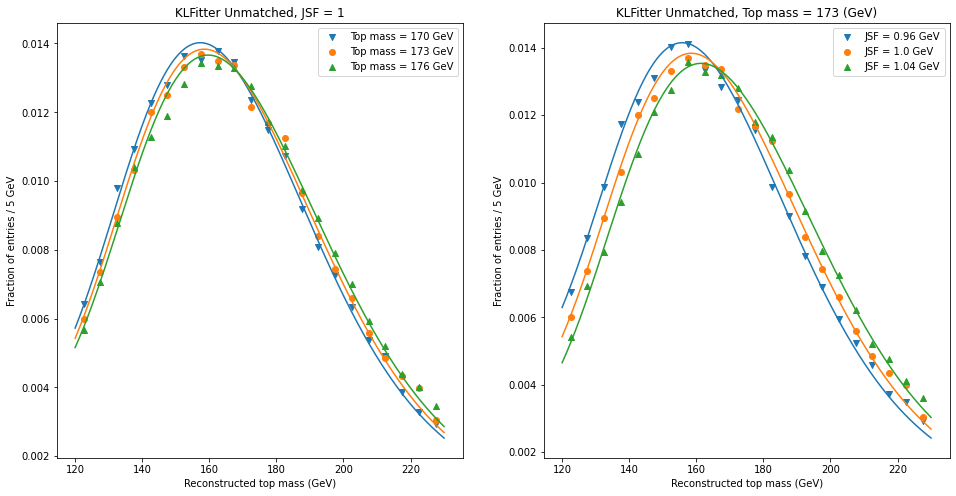

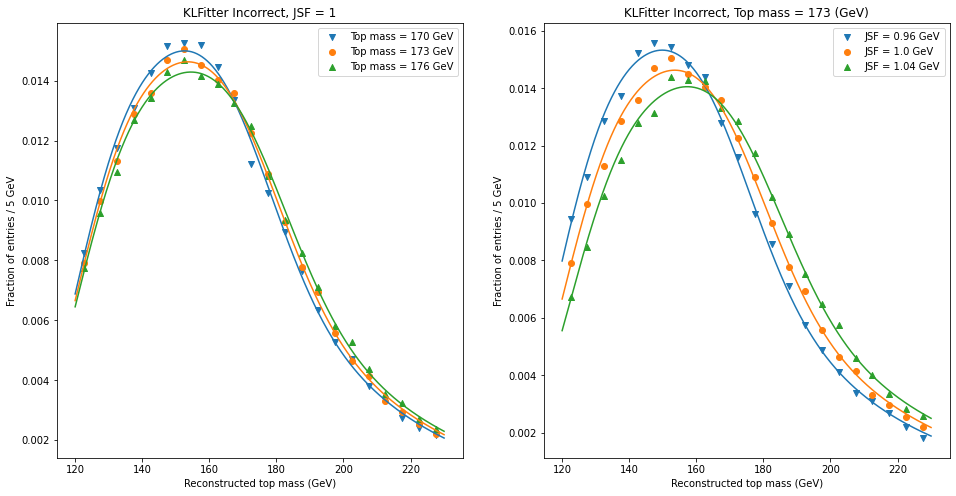

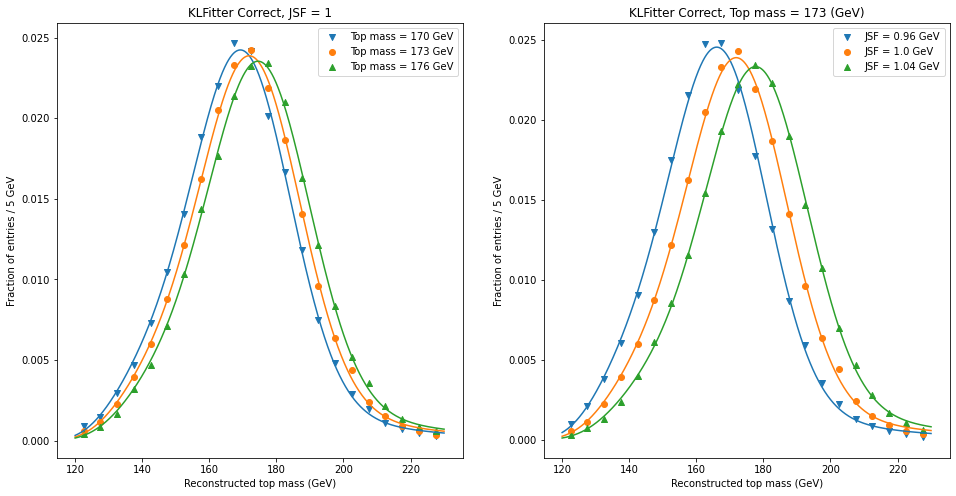

In [7]:
for state_i in states:
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    JSF = 1
    bins = np.arange(top_bins_min, top_bins_max+1, 5)
    marker_arr = ['v', 'o', '^']

    for i, m in enumerate([170, 173, 176]):
        fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
        popt = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

    plt.title(f'KLFitter {state_labels[state_i]}, JSF = 1')
    plt.xlabel('Reconstructed top mass (GeV)')
    plt.ylabel('Fraction of entries / 5 GeV')
    plt.legend()

    m = 173
    plt.subplot(1,2,2)
    for i, JSF in enumerate(JSF_arr):
        fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
        popt = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

    plt.title(f'KLFitter {state_labels[state_i]}, Top mass = 173 (GeV)')
    plt.xlabel('Reconstructed top mass (GeV)')
    plt.ylabel('Fraction of entries / 5 GeV')
    plt.legend()
    plt.savefig(f'plots_topmass_JSF/thesis_plots/KLFitter top {state_labels[state_i]} distribution.png', bbox_inches='tight')
    plt.show()

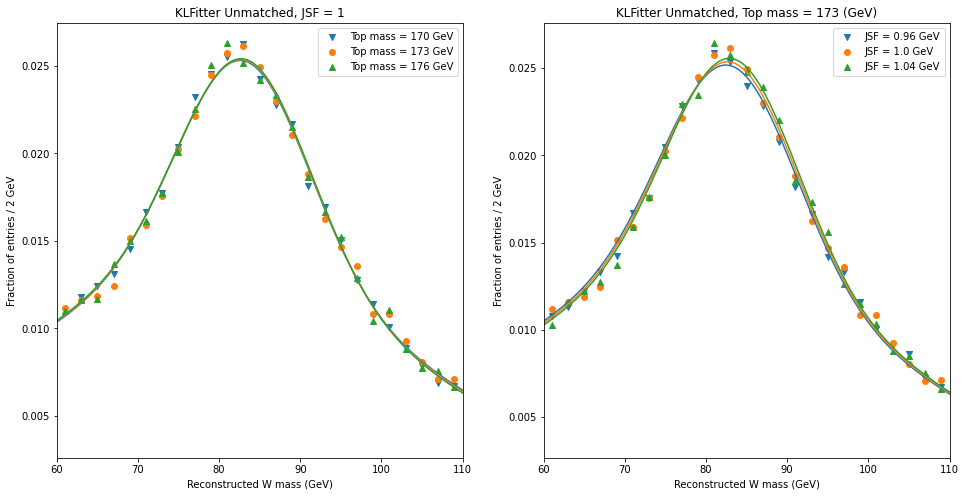

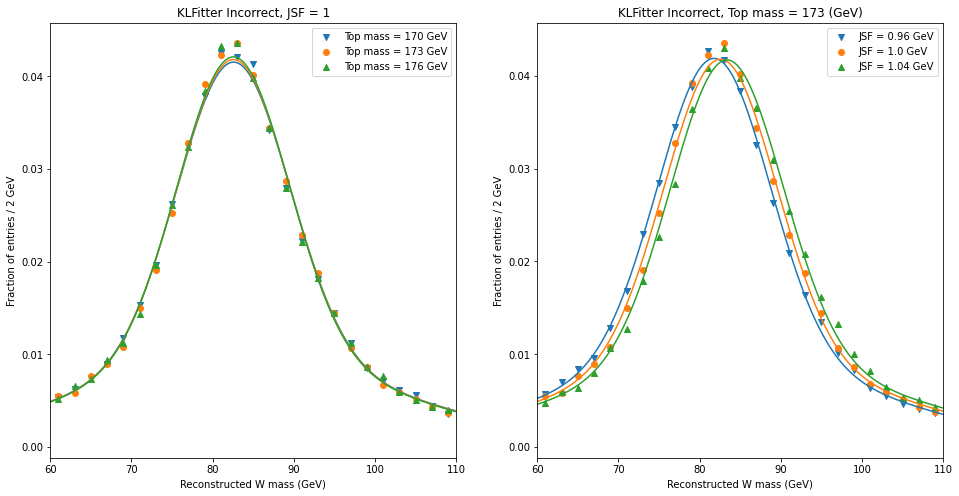

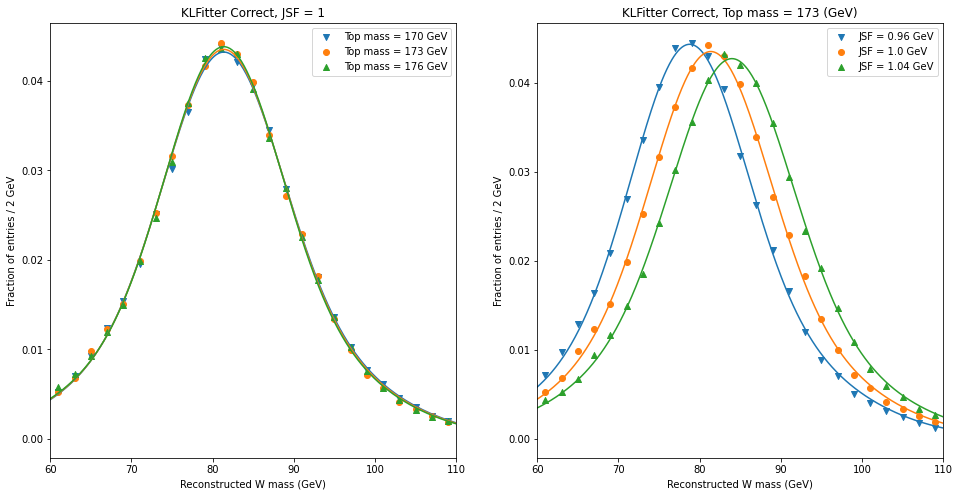

In [8]:
for state_i in states:
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    JSF = 1
    bins = np.arange(W_bins_min, W_bins_max+1, 2)
    marker_arr = ['v', 'o', '^']

    for i, m in enumerate([170, 173, 176]):
        fit_target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
        popt = [linear_linear((m, JSF), *pdf_klf_W_dic[(state_i, j)]) for j in range(5)]
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

    plt.title(f'KLFitter {state_labels[state_i]}, JSF = 1')
    plt.xlabel('Reconstructed W mass (GeV)')
    plt.ylabel('Fraction of entries / 2 GeV')
    plt.xlim(60, 110)
    plt.legend()

    m = 173
    plt.subplot(1,2,2)
    for i, JSF in enumerate(JSF_arr):
        fit_target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
        popt = [linear_linear((m, JSF), *pdf_klf_W_dic[(state_i, j)]) for j in range(5)]
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

    plt.title(f'KLFitter {state_labels[state_i]}, Top mass = 173 (GeV)')
    plt.xlabel('Reconstructed W mass (GeV)')
    plt.ylabel('Fraction of entries / 2 GeV')
    plt.legend()
    plt.xlim(60, 110)
    plt.savefig(f'plots_topmass_JSF/thesis_plots/KLFitter W {state_labels[state_i]} distribution.png', bbox_inches='tight')
    plt.show()

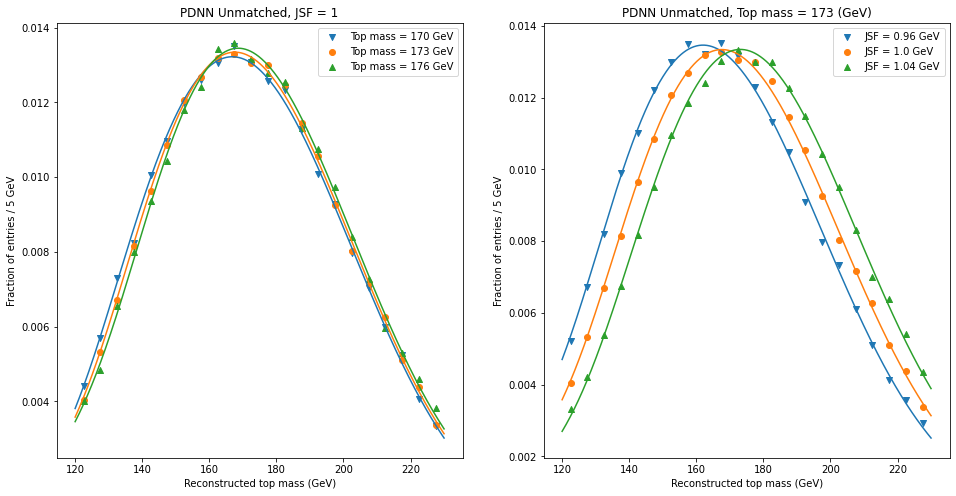

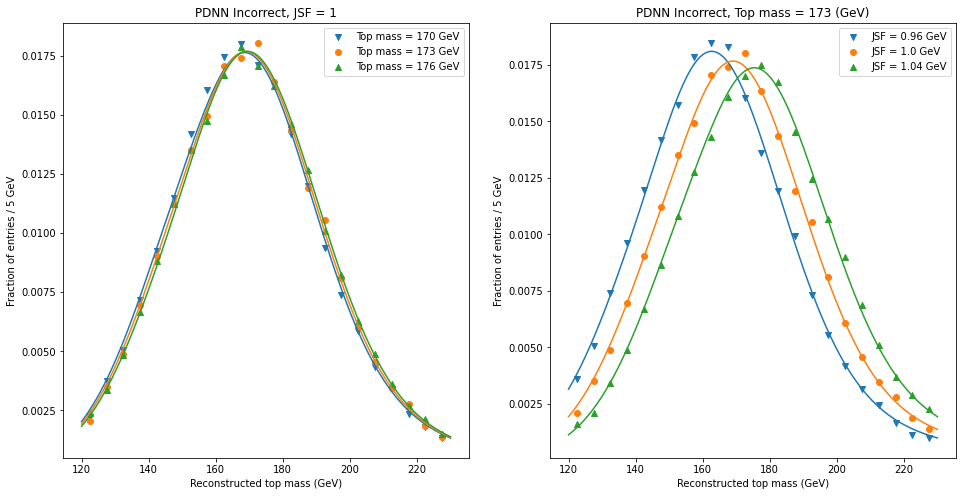

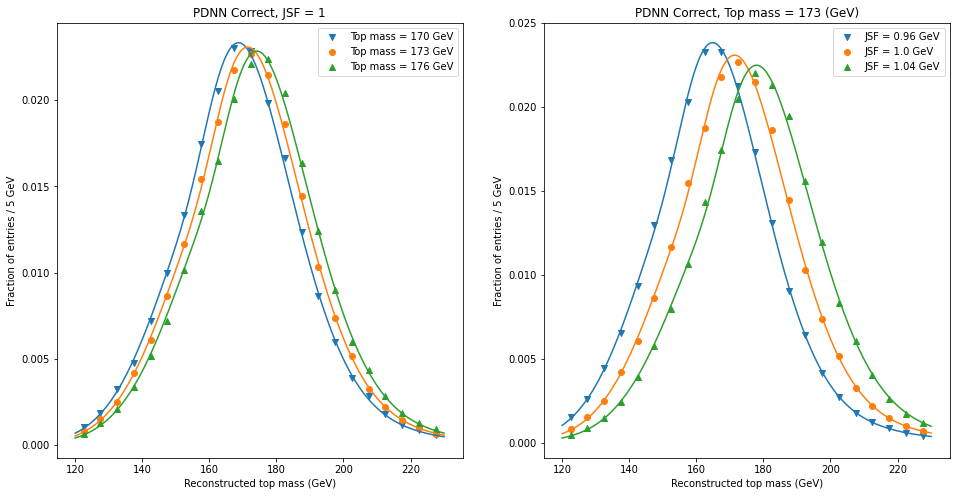

In [9]:
for state_i in states:
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    JSF = 1
    bins = np.arange(top_bins_min, top_bins_max+1, 5)
    marker_arr = ['v', 'o', '^']

    for i, m in enumerate([170, 173, 176]):
        fit_target = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
        popt = [linear_linear((m, JSF), *pdf_pdnn_top_dic[(state_i, j)]) for j in range(5)]
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

    plt.title(f'PDNN {state_labels[state_i]}, JSF = 1')
    plt.xlabel('Reconstructed top mass (GeV)')
    plt.ylabel('Fraction of entries / 5 GeV')
    plt.legend()

    m = 173
    plt.subplot(1,2,2)
    for i, JSF in enumerate(JSF_arr):
        fit_target = reco_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
        popt = [linear_linear((m, JSF), *pdf_pdnn_top_dic[(state_i, j)]) for j in range(5)]
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

    plt.title(f'PDNN {state_labels[state_i]}, Top mass = 173 (GeV)')
    plt.xlabel('Reconstructed top mass (GeV)')
    plt.ylabel('Fraction of entries / 5 GeV')
    plt.legend()
    plt.savefig(f'plots_topmass_JSF/thesis_plots/PDNN top {state_labels[state_i]} distribution.png', bbox_inches='tight')
    plt.show()

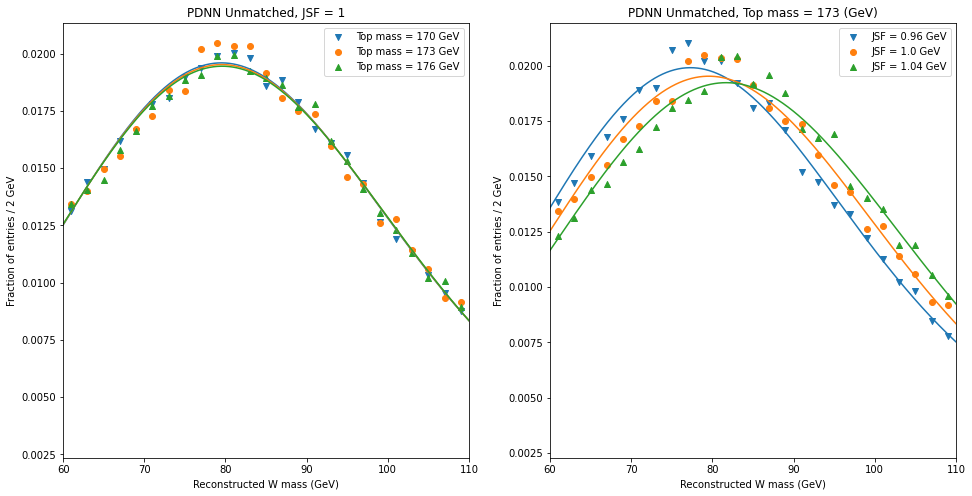

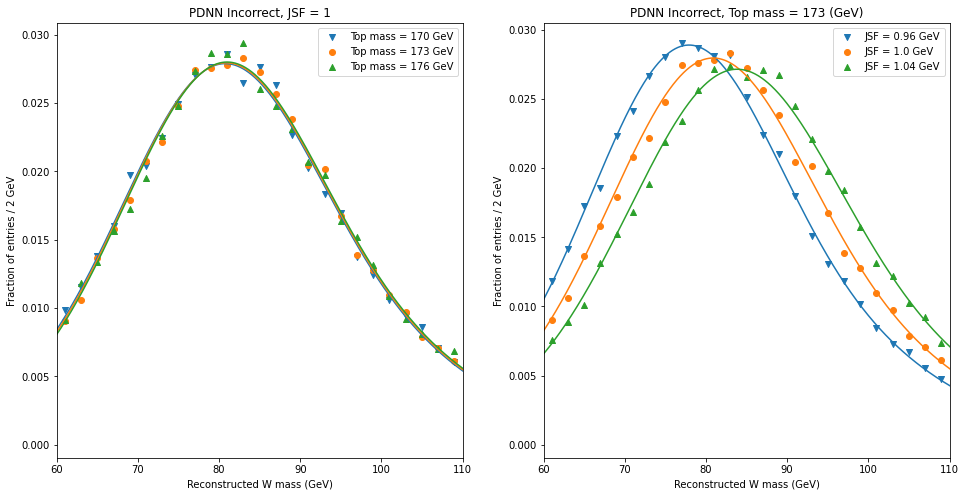

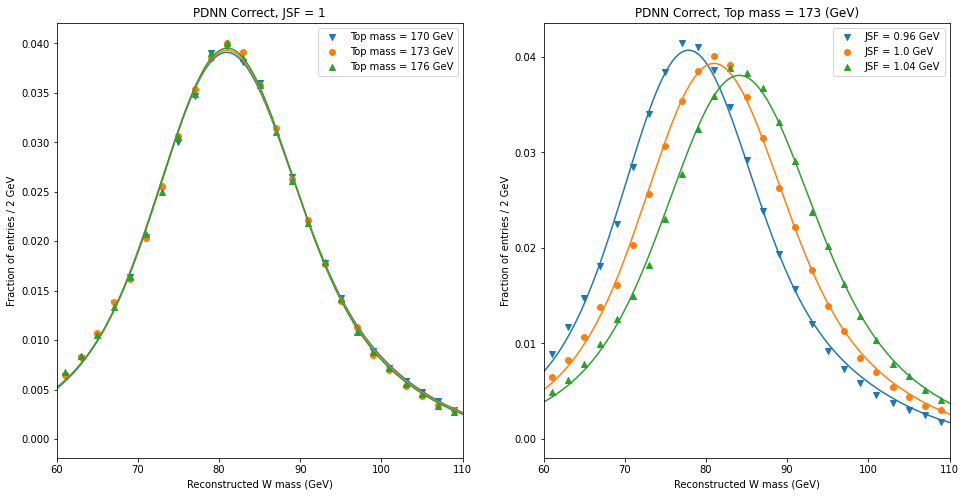

In [10]:
for state_i in states:
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    JSF = 1
    bins = np.arange(W_bins_min, W_bins_max+1, 2)
    marker_arr = ['v', 'o', '^']

    for i, m in enumerate([170, 173, 176]):
        fit_target = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
        popt = [linear_linear((m, JSF), *pdf_pdnn_W_dic[(state_i, j)]) for j in range(5)]
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

    plt.title(f'PDNN {state_labels[state_i]}, JSF = 1')
    plt.xlabel('Reconstructed W mass (GeV)')
    plt.ylabel('Fraction of entries / 2 GeV')
    plt.xlim(60, 110)
    plt.legend()

    m = 173
    plt.subplot(1,2,2)
    for i, JSF in enumerate(JSF_arr):
        fit_target = W_pdnn_dic[(m, JSF)][np.logical_and.reduce((cut_pdnn_dic[(m, JSF)], likeli_pdnn_dic[(m, JSF)], state_pdnn_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
        popt = [linear_linear((m, JSF), *pdf_pdnn_W_dic[(state_i, j)]) for j in range(5)]
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

    plt.title(f'PDNN {state_labels[state_i]}, Top mass = 173 (GeV)')
    plt.xlabel('Reconstructed W mass (GeV)')
    plt.ylabel('Fraction of entries / 2 GeV')
    plt.legend()
    plt.xlim(60, 110)
    plt.savefig(f'plots_topmass_JSF/thesis_plots/PDNN W {state_labels[state_i]} distribution.png', bbox_inches='tight')
    plt.show()

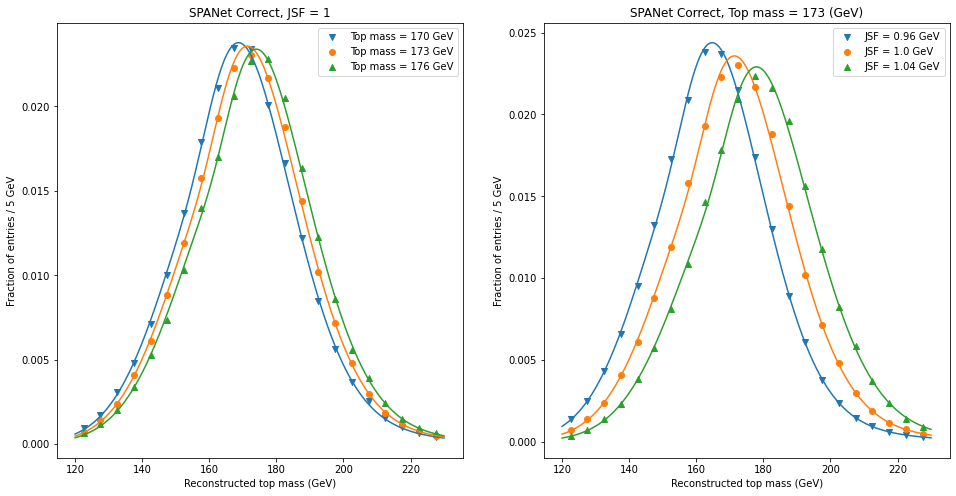

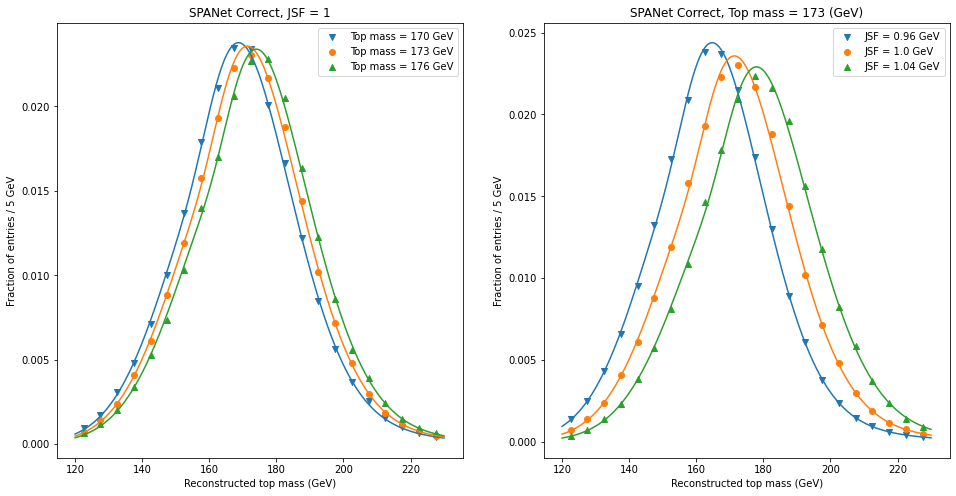

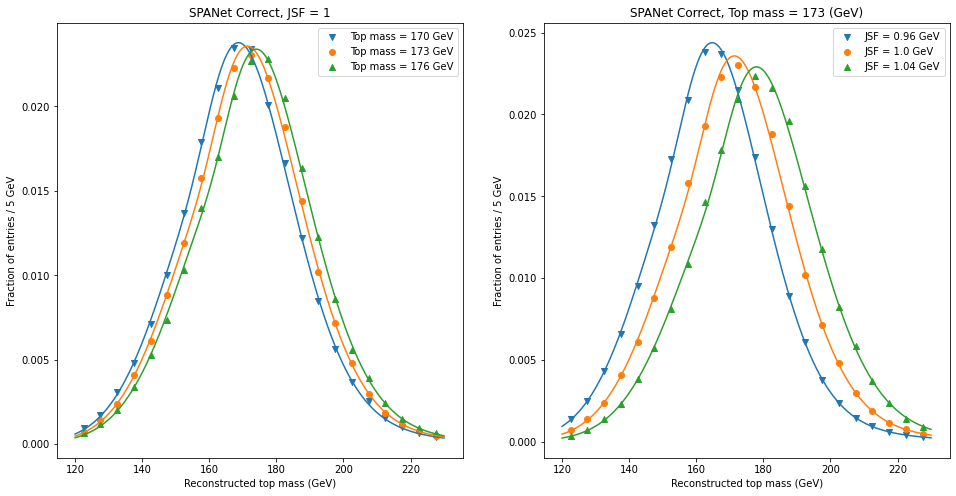

In [11]:
for state_i in states:
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    state_i = 2
    JSF = 1
    bins = np.arange(top_bins_min, top_bins_max+1, 5)
    marker_arr = ['v', 'o', '^']

    for i, m in enumerate([170, 173, 176]):
        fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
        popt = [linear_linear((m, JSF), *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

    plt.title(f'SPANet {state_labels[state_i]}, JSF = 1')
    plt.xlabel('Reconstructed top mass (GeV)')
    plt.ylabel('Fraction of entries / 5 GeV')
    plt.legend()

    m = 173
    plt.subplot(1,2,2)
    for i, JSF in enumerate(JSF_arr):
        fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
        popt = [linear_linear((m, JSF), *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

    plt.title(f'SPANet {state_labels[state_i]}, Top mass = 173 (GeV)')
    plt.xlabel('Reconstructed top mass (GeV)')
    plt.ylabel('Fraction of entries / 5 GeV')
    plt.legend()
    plt.savefig(f'plots_topmass_JSF/thesis_plots/SPANet top {state_labels[state_i]} distribution.png', bbox_inches='tight')
    plt.show()

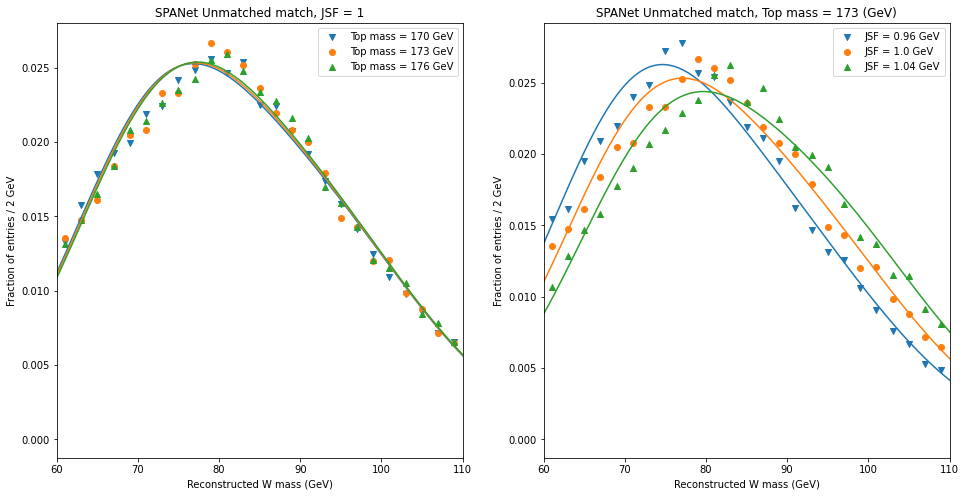

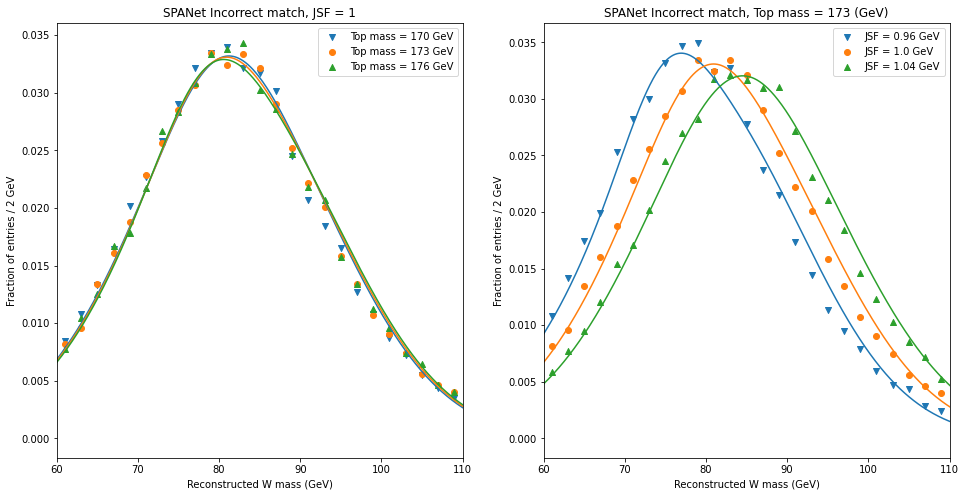

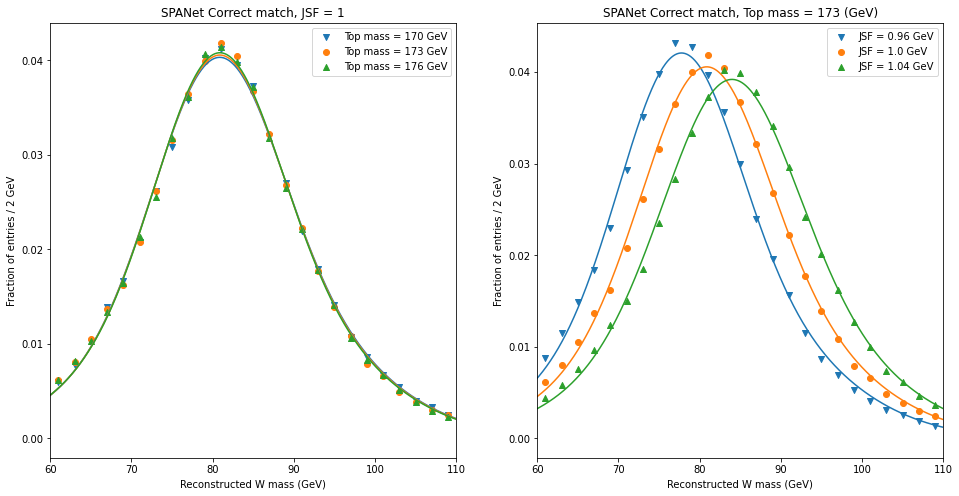

In [12]:
for state_i in states:
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    JSF = 1
    bins = np.arange(W_bins_min, W_bins_max+1, 2)
    marker_arr = ['v', 'o', '^']

    for i, m in enumerate([170, 173, 176]):
        fit_target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
        popt = [linear_linear((m, JSF), *pdf_spanet_W_dic[(state_i, j)]) for j in range(5)]
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

    plt.title(f'SPANet {state_labels[state_i]} match, JSF = 1')
    plt.xlabel('Reconstructed W mass (GeV)')
    plt.ylabel('Fraction of entries / 2 GeV')
    plt.xlim(60, 110)
    plt.legend()

    m = 173
    plt.subplot(1,2,2)
    for i, JSF in enumerate(JSF_arr):
        fit_target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
        popt = [linear_linear((m, JSF), *pdf_spanet_W_dic[(state_i, j)]) for j in range(5)]
        plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

    plt.title(f'SPANet {state_labels[state_i]} match, Top mass = 173 (GeV)')
    plt.xlabel('Reconstructed W mass (GeV)')
    plt.ylabel('Fraction of entries / 2 GeV')
    plt.legend()
    plt.xlim(60, 110)
    plt.savefig(f'plots_topmass_JSF/thesis_plots/SPANet W {state_labels[state_i]} distribution.png', bbox_inches='tight')
    plt.show()

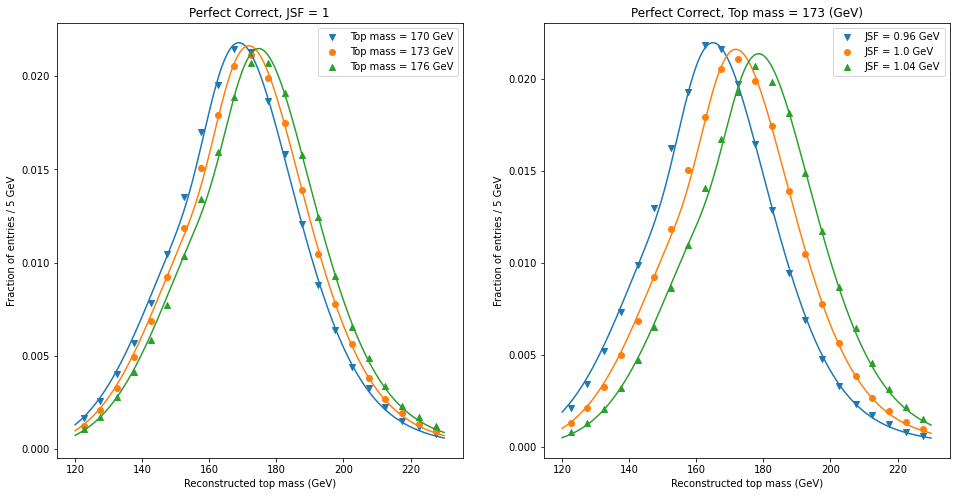

In [13]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
state_i = 2
JSF = 1
bins = np.arange(top_bins_min, top_bins_max+1, 5)
marker_arr = ['v', 'o', '^']

for i, m in enumerate([170, 173, 176]):
    fit_target = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(fit_target, bins=bins, density=True)
    plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
    popt = [linear_linear((m, JSF), *pdf_perfect_top_dic[(state_i, j)]) for j in range(5)]
    plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

plt.title('Perfect Correct, JSF = 1')
plt.xlabel('Reconstructed top mass (GeV)')
plt.ylabel('Fraction of entries / 5 GeV')
plt.legend()

m = 173
plt.subplot(1,2,2)
for i, JSF in enumerate(JSF_arr):
    fit_target = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(fit_target, bins=bins, density=True)
    plt.scatter(bins[:-1]+2.5, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
    popt = [linear_linear((m, JSF), *pdf_perfect_top_dic[(state_i, j)]) for j in range(5)]
    plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt))

plt.title('Perfect Correct, Top mass = 173 (GeV)')
plt.xlabel('Reconstructed top mass (GeV)')
plt.ylabel('Fraction of entries / 5 GeV')
plt.legend()
plt.savefig(f'plots_topmass_JSF/thesis_plots/Perfect top {state_labels[state_i]} distribution.png', bbox_inches='tight')
plt.show()

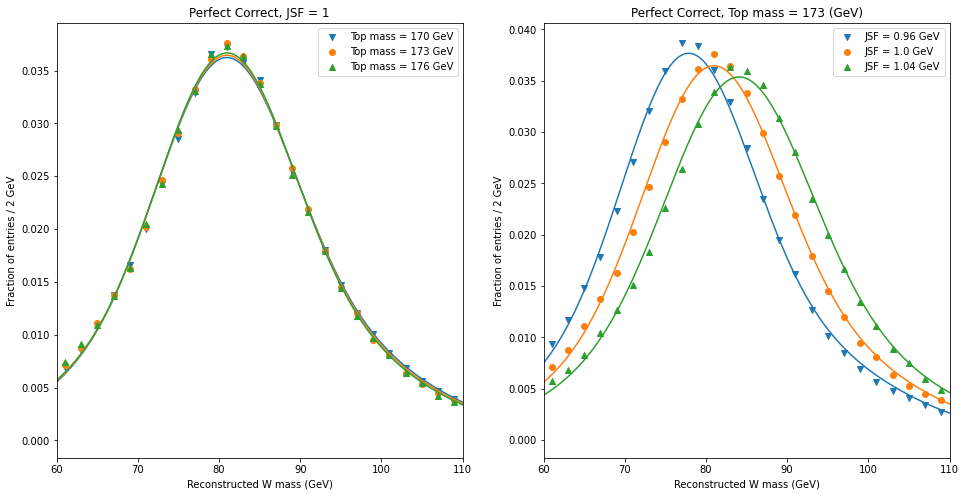

In [14]:
state_i = 2
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
JSF = 1
bins = np.arange(W_bins_min, W_bins_max+1, 2)
marker_arr = ['v', 'o', '^']

for i, m in enumerate([170, 173, 176]):
    fit_target = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(fit_target, bins=bins, density=True)
    plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i], label = f'Top mass = {m} GeV')
    popt = [linear_linear((m, JSF), *pdf_perfect_W_dic[(state_i, j)]) for j in range(5)]
    plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

plt.title(f'Perfect {state_labels[state_i]}, JSF = 1')
plt.xlabel('Reconstructed W mass (GeV)')
plt.ylabel('Fraction of entries / 2 GeV')
plt.xlim(60, 110)
plt.legend()

m = 173
plt.subplot(1,2,2)
for i, JSF in enumerate(JSF_arr):
    fit_target = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)]==state_i))]
    hist, _ = np.histogram(fit_target, bins=bins, density=True)
    plt.scatter(bins[:-1]+1, hist, marker=marker_arr[i] , label = f'JSF = {JSF} GeV')
    popt = [linear_linear((m, JSF), *pdf_perfect_W_dic[(state_i, j)]) for j in range(5)]
    plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt))

plt.title(f'Perfect {state_labels[state_i]}, Top mass = 173 (GeV)')
plt.xlabel('Reconstructed W mass (GeV)')
plt.ylabel('Fraction of entries / 2 GeV')
plt.legend()
plt.xlim(60, 110)
plt.savefig(f'plots_topmass_JSF/thesis_plots/Perfect W {state_labels[state_i]} distribution.png', bbox_inches='tight')
plt.show()